# Ensemble Learning

In [1]:
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import log_loss
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import xgboost as xgb
%matplotlib inline

## Dataset

Simulated dataset of 1000 samples x 20 features (10 redundant features, and 8 useless features).  
Number of classes = 3

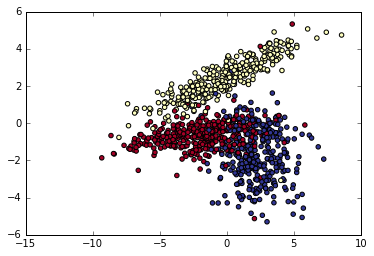

In [2]:
X, y = make_classification(n_samples=1000, n_features=20, n_informative=2, n_redundant=10, n_classes=3,
                           n_clusters_per_class=1, random_state=1010)
X_reduced = PCA(n_components=2).fit_transform(X)
plt.scatter(X_reduced[:,0], X_reduced[:,1], marker='o', c=y, cmap=plt.cm.RdYlBu)

## Model Evaluation

*Note that the models aren't tuned/optimized and hence their performance cannot be compared.*

Each model is evaluated by a 5-fold CV and logloss metric is used to assess model performance.
$$
log loss = -\frac{1}{N} \sum_{i=1}^N \sum_{j=1}^M y_{ij}\log(p_{ij})
$$

In [3]:
# create contour plot of the decision surface
def decision_boundary(clf):
    x_min, x_max = X_reduced[:, 0].min() - 1, X_reduced[:, 0].max() + 1
    y_min, y_max = X_reduced[:, 1].min() - 1, X_reduced[:, 1].max() + 1

    xx_fine, yy_fine = np.meshgrid(np.arange(x_min, x_max, 0.05), np.arange(y_min, y_max, 0.05))
    estimator_alpha = 1.0 / clf.n_estimators
    for tree in clf.estimators_:
        z_fine = tree.predict(np.c_[xx_fine.ravel(), yy_fine.ravel()]).reshape(xx_fine.shape)
        cs = plt.contourf(xx_fine, yy_fine, z_fine, alpha=estimator_alpha, cmap=plt.cm.RdYlBu)

    xx_coarser, yy_coarser = np.meshgrid(np.arange(x_min, x_max, 0.5), np.arange(y_min, y_max, 0.5))
    z_coarser = clf.predict(np.c_[xx_coarser.ravel(), yy_coarser.ravel()]).reshape(xx_coarser.shape)
    cs_points = plt.scatter(xx_coarser, yy_coarser, s=15, c=z_coarser, cmap=plt.cm.RdYlBu, edgecolors="none")

    for i, c in zip(range(len(np.unique(y))), "ryb"):
        idx = np.where(y == i)
        plt.scatter(X_reduced[idx, 0], X_reduced[idx, 1], c=c, cmap=plt.cm.RdYlBu)

In [4]:
# evaluate 5-fold cv logloss
def eval_score(clf, name, verbose=0):
    scores = cross_val_score(clf, X, y, scoring='log_loss', cv=5, 
                             verbose=verbose)
    print(name, "logloss: {0:.6f} +/- {1:.6f}".format(scores.mean(), scores.std()))

## Forests of Randomized Trees

### Random Forest

In random forests each tree in the ensemble is built from a bootstrap sample from the training set. In addition, when splitting a node during the construction of the tree, the split that is picked is the best split among a random subset of the features.  Given a training set $X = x_1, ..., x_n$,
with responses $Y = y_1, ..., y_n$, prediction of a forest for an unseen sample $x'$ is the average of predictions of its individual trees:
$$
{\hat {f}}={\frac {1}{B}}\sum _{b=1}^{B}{\hat {f}}_{b}(x')
$$
where  
$f_b$ is the $b$-th decision tree, and  
$B$ is the number of trees or classifiers in the forest.

An upper bound for the generalization error is given by:
$$PE^* \leq \bar\rho\,(1−s^2 ) / s^2,$$
where  
$\bar\rho$ is the mean value of correlation between the classifiers, and  
$s$ is the strength of the set of classifiers.  
  
The generalization error approaches a limiting value as more trees are added.

In [5]:
clf_rf = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=22, min_samples_leaf=65, 
                                max_features='sqrt', bootstrap=True, n_jobs=-1, random_state=880)
eval_score(clf_rf, 'RF')

RF logloss: -0.359672 +/- 0.025764


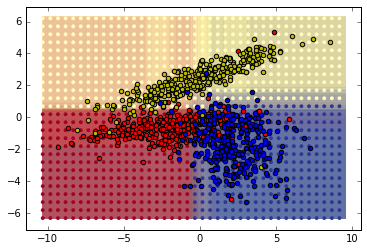

In [6]:
clf_rf.fit(X_reduced, y)
decision_boundary(clf_rf)

### Extra Trees

As in random forests, a random subset of candidate features is used, but instead of looking for the most discriminative thresholds, thresholds are drawn at random for each candidate feature and the best of these randomly-generated thresholds is picked as the splitting rule. Let us consider a learning sample of size $N$
$$
l_{SN} = \{(x^i, y^i): i = 1,...,N\},
$$
where each $x^i$ is an attribute vector of dimension $n$ and $y^i$ is the corresponding output value, by $I_{(i_1,...,i_n)}(x)$ the characteristic function of the hyper-interval
$[x_1^{(i_1)}, x_1^{(i_1+1)}[ \, \times ... \times \, [x_n^{(i_n)}, x_n^{(i_n+1)}[$
formed from $x_j$ by taking the sample values of $j$-th attribute in increasing order. An infinite ensemble of extra trees provides an approximation in the form of
$$
\hat y(x) =  \sum_{i_1=1}^N ... \sum_{i_n=0}^N I(i_1,...,i_n)(x) \sum_{X \subset \{x_1...x_n\}}
\lambda^X_{(i_1,...,i_n)} \prod_{x_j \in X} x_j,
$$
$\lambda$ depends on $x^i$, $y^i$, $K$ (max features selected at each node) and $n_{min}$ (min split sample size)

In [7]:
clf_et = ExtraTreesClassifier(n_estimators=100, criterion='gini', max_depth=10, min_samples_leaf=1,
                              max_features='sqrt', bootstrap=False, n_jobs=-1, random_state=1011)
eval_score(clf_et, 'ET')

ET logloss: -0.327050 +/- 0.100595


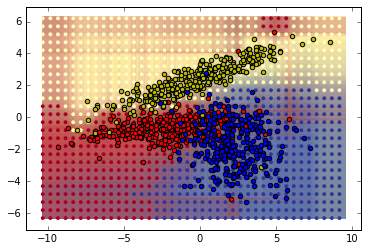

In [8]:
clf_et.fit(X_reduced, y)
decision_boundary(clf_et)

## Boosting

Suppose we have a data set $\{(x_{1},y_{1}),\ldots ,(x_{N},y_{N})\}$ where each item $x_{i}$ has an associated class $y_{i} \in \{-1,1\}$ and a set of weak classifiers $\{k_{1},\ldots ,k_{L}\}$ each of which outputs a classification $k_{j}(x_{i})\in \{-1,1\}$ for each item. After the $m−1$-th iteration our boosted classifier is a linear combination of the weak classifiers of the form:
$$
C_{{(m-1)}}(x_{i})=\alpha _{1}k_{1}(x_{i})+\cdots +\alpha _{{m-1}}k_{{m-1}}(x_{i})
$$

### AdaBoost

* Chooses the classifier $k_m$ which minimizes, 
    $$
    W_e = \sum_{y_i \neq k_m(x_i)} {w_i^{(m)}}.
    $$  
* Weight of the classifier, 
    $$
    \alpha_m = \frac{1}{2} \ln \frac{1 - e_m}{e_m}, \text {where } {e_m = W_e / W}
    $$
* Weight of the data points for the next iteration, if $k^m(x_i)$ is a miss
    $$
    w_i^{(m+1)} = w_i^{(m)} e^{\alpha_m}
    $$
    otherwise,
    $$
    w_i^{(m+1)} = w_i^{(m)} e^{-\alpha_m}.
    $$

In [9]:
clf_adc = AdaBoostClassifier(n_estimators=8, learning_rate=0.1, random_state=1010, algorithm='SAMME.R')
eval_score(clf_adc, 'AdaBoost')

AdaBoost logloss: -0.509680 +/- 0.030940


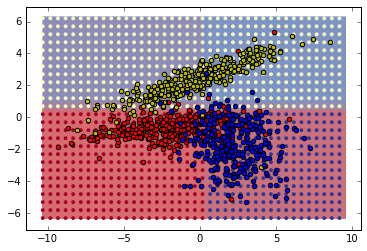

In [10]:
clf_adc.fit(X_reduced, y)
decision_boundary(clf_adc)

### Gradient Boosting

Given a training sample, $\{y_i, x_i\}_1^N$ of known $(y, x)$ values, the goal is to find a function $F^*(x)$ that maps $x$ to $y$, such that over the joint distribution of all $(y, x)$-values, the expected value of some specified loss function $\Psi(y, F(x))$ is minimized
$$
{\displaystyle F^*(x) = {\underset {F(x)}{\arg \min}} \, \mathbb {E} _{y,x} \, \Psi(y, F(x))} . 
$$
Boosting approximates $F^*(x)$ by an additive expansion of the form
$$
F(x) = \sum_{m = 0}^M {\beta_m h(x; a_m)},
$$
where the functions $h(x; a)$ are the base learners. The expansion coefficients $\{\beta_m\}_0^M$ and the parameters $\{a_m\}_0^M$ are jointly fit to the data in a forward stagewise manner.
$$
(\beta_m, a_m) = {\underset {\beta,a}{\arg \min}} \, \sum_{i=1}^N \Psi(y_i, F_{m-1}(x_i) + \beta \, h(x_i; a))
$$
and
$$
F_m(x) = F_{m-1}(x) + \beta \, h(x; a_m).
$$
In gradient boosting, the function $h(x; a)$ is fit by least-squares
$$
a_m = {\underset {a,\,\rho}{\arg \min}} \sum_{i=1}^N [\, \tilde y _{im} - \rho h(x_i; a)]^2
$$
to the current _pseudo-residuals_,
$$
\tilde y _{im} = -[{\frac {\partial {\Psi(y_i,F(x_i))}}{\partial F(x_i)}}]_{F(x)=F_{m-1}(x)}
$$
Then, given $h(x; a_m)$, the optimal value of the coefficient $\beta_m$ is determined
$$
\beta_m = {\underset {\beta}{\arg \min}} \, \sum_{i=1}^N \Psi(y_i, F_{m-1}(x_i) + \beta \, h(x_i; a_m)).
$$
When the base learner $h(x; a)$ is a $L$-terminal node regression tree,
$$
h(x; \{R_{lm}\}_1^L) = \sum_{l=1}^L \tilde y _{lm} \, \mathbf 1 (x \in R_{lm})
$$
Here $\tilde y _{lm} = mean_{x_i \in R_{lm}}(\tilde y _{im})$ is the mean of pseudo residuals of each region $R_{lm} \in \{R_{lm}\}_{l=1}^L$, the set of L-disjoint partitions of $x$-space created by the regression tree. Since the regression tree predicts a constant value within each region, the solution reduces to,
$$
\gamma_{lm} = {\underset {\gamma}{\arg \min}} \sum_{x_i \in R_{lm}} \Psi(y_i, F_{m-1}(x_i) + \gamma), \\ 
F_m(x) = F_{m-1}(x) + \nu . \gamma_{lm} \, \mathbf 1 (x \in R_{lm}).
$$
The shrinkage parameter $0 < \nu \le 1$ controls the learning rate of the procedure.

In [11]:
dtrain = xgb.DMatrix(X_reduced, y)
params = {'eta': 0.03,
          'max_depth': 3,
          'min_child_weight': 1,
          'subsample': 1,
          'colsample_bylevel': 1,
          'objective': 'multi:softprob',
          'eval_metric': 'mlogloss',
          'num_class': 3}
eval_res = xgb.cv(params, dtrain, num_boost_round=400, nfold=5, stratified=True,
                  early_stopping_rounds=None, verbose_eval=False)

Best iteration and score:

In [12]:
best_iter = eval_res['test-mlogloss-mean'].argmin()
eval_res.iloc[best_iter,:]

test-mlogloss-mean     0.310658
test-mlogloss-std      0.028053
train-mlogloss-mean    0.194817
train-mlogloss-std     0.003189
Name: 211, dtype: float64

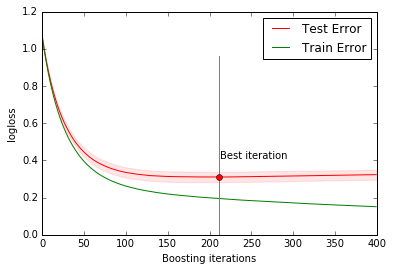

In [13]:
iter_x = np.arange(eval_res.shape[0])
plt.plot(iter_x, eval_res['test-mlogloss-mean'], 'r-')
plt.fill_between(iter_x,
                 eval_res['test-mlogloss-mean'] - eval_res['test-mlogloss-std'],
                 eval_res['test-mlogloss-mean'] + eval_res['test-mlogloss-std'],
                 color='red', alpha=0.1)
plt.plot(iter_x, eval_res['train-mlogloss-mean'], 'g-')
plt.axvline(best_iter, ymax=0.8, linewidth=1, color='gray')
best_score = eval_res.loc[best_iter, 'test-mlogloss-mean']
plt.plot(best_iter, best_score, marker='o', color='red')
plt.annotate('Best iteration', xy=(best_iter, best_score), xytext=(best_iter+1, best_score+0.1))
plt.xlabel('Boosting iterations')
plt.ylabel('logloss')
test_legend = mlines.Line2D([], [], color='red', label='Test Error')
train_legend = mlines.Line2D([], [], color='green', label='Train Error')
plt.legend(handles=[test_legend, train_legend])

## Bagging

Given a learning set $\mathcal L$ of data $\{(y_n, x_n), n = 1,\ldots,N\}$ where the $y$'s are either class labels or a numerical response, assume we have a procedure for using this learning set to form a predictor $\varphi(x, \mathcal L)$. Suppose we are limited to this single learning set $\mathcal L$ without luxury of replicates of $\mathcal L$, take repeated bootstrap samples $\{\mathcal L^{(B)}\}$ from $\mathcal L$, and form $\{\varphi(x, \mathcal L^{(B)}\}$. The $\{\mathcal L^{(B)}\}$ are replicate data sets drawn from the bootstrap distribution approximating the distribution underlying $\mathcal L$. If y is numerical, take $\varphi_B$ as
$\varphi_B(x) = {av}_B \varphi(x, \mathcal L^{(B)})$. If y is class label, $\{\varphi(x, \mathcal L^{(B)}\}$ vote to form $\varphi_B(x)$. This procedure is called __boostrap aggregating__ or __bagging__.

In the following example a bagging regressor is designed to approximate a non linear function
$$
\newcommand\abs[1]{\left|#1\right|}
f(x) = \log \abs {1+x\,} (2 + \sin {2 x}).
$$
Instead of building a single KNN regressor on the complete dataset, multiple KNN regressors are fit on different bootstrap samples and bagged into a single predictor.

In [14]:
def f(x):
    x = x.ravel()
    return np.log(x + 1) * (2 + np.sin(2 * x))

def generate(n_samples):
    X = np.random.rand(n_samples) * 10
    X = np.sort(X)
    y = f(X) + np.random.normal(0.0, 0.5, n_samples)
    return X.reshape(-1, 1), y

np.random.seed(183872680)
n_samples = 100
X_train, y_train = generate(n_samples)
X_test, y_test = generate(n_samples)

knn = KNeighborsRegressor(n_neighbors=10, weights='uniform', algorithm='auto', leaf_size=30)
knn.fit(X_train, y_train)

model_bag = BaggingRegressor(base_estimator=knn, n_estimators=100, max_samples=0.8, max_features=1.0, 
                           bootstrap=True, bootstrap_features=False, random_state=12020, verbose=0)
model_bag.fit(X_train, y_train)

BaggingRegressor(base_estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=10, p=2,
          weights='uniform'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.8, n_estimators=100, n_jobs=1, oob_score=False,
         random_state=12020, verbose=0, warm_start=False)

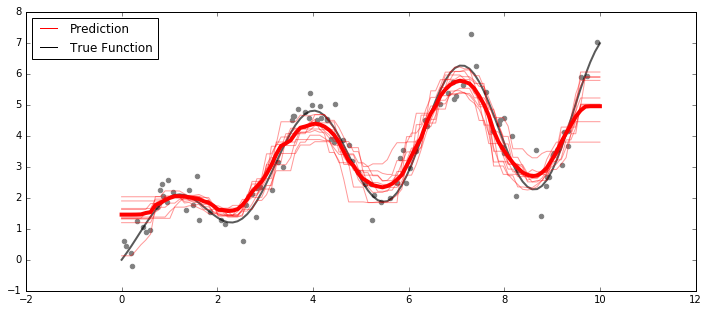

In [15]:
X_plt = np.linspace(0, 10, 100).reshape(-1, 1)
plt.figure(figsize=(12, 5))
plt.scatter(X_test.ravel(), y_test, color='gray')
plt.plot(X_plt, f(X_plt), 'k-', alpha=0.65, linewidth=2)
for est in model_bag.estimators_[:10]:
    plt.plot(X_plt, est.predict(X_plt), 'r-', alpha=0.4)
plt.plot(X_plt, model_bag.predict(X_plt), 'r-', linewidth=4)
test_legend = mlines.Line2D([], [], color='red', label='Prediction')
train_legend = mlines.Line2D([], [], color='black', label='True Function')
plt.legend(handles=[test_legend, train_legend], loc='best')

## Model Blending

Blending predictions is a supervised learning problem, very similar to _stacked generalization_. Let $\theta$ denote the learning set of $m$ elements living in the input space $\mathcal {X \times Y}$, and $g_1, \ldots, g_L$ denote the prediction functions of $L$ machine learning models $\{G_j\}$ with $g_i: \mathcal X \rightarrow \mathbb R, \forall i$. The first step in blending is to split $\theta$ into two disjoint sets, $\theta_1$ and $\theta_2$. The training data for each model $G_i$ is limited to $\theta_1$. Let $g(x)$ denote the $L$-dimensional vector $\langle g_1(x), \ldots, g_L(x) \rangle$ formed from individual predictions. The blending algorithm is formally a function $\Omega: \mathbb R^L \rightarrow \mathbb R$. The blending model is fit on the set $\{(g(x), y) \,|\, (x, y) \in \theta_2\}$, and the prediction for an input $x \in \mathcal X$ is given by $\Omega(g(x))$. 

The following examples illustrates blending of three classifiers (RF, ExtraTrees, GBRT) with a Logistic regression model.

In [17]:
def blend(clfs, blend_clf, n_folds, X, y, X_sub, verbose_eval=lambda x: None):
    np.random.seed(1010)
    dataset_blend_train = np.zeros((X.shape[0], len(clfs)))
    dataset_blend_test = np.zeros((X_sub.shape[0], len(clfs)))
    skf = StratifiedKFold(y, n_folds=5, shuffle=True)
    for j, clf in enumerate(clfs):
        print(j, clf)
        dataset_blend_test_j = np.zeros((X_sub.shape[0], len(skf)))
        for i, (train_idx, test_idx) in enumerate(skf):
            print("Fold", i)
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            clf.fit(X_train, y_train)
            dataset_blend_train[test_idx, j] = clf.predict_proba(X_test)[:,1]
            dataset_blend_test_j[:,i] = clf.predict_proba(X_sub)[:,1]
        verbose_eval(clf)
        dataset_blend_test[:,j] = dataset_blend_test_j.mean(1)
    print("Blending...")
    blend_clf.fit(dataset_blend_train, y)
    y_sub_pred = blend_clf.predict_proba(dataset_blend_test)[:,1]
    return y_sub_pred


X, y = make_classification(n_samples=10000, n_features=20, n_informative=3, n_classes=2,
                           n_redundant=10, flip_y=0.5, random_state=1010)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=y,
                                                    random_state=1810)

clfs = [RandomForestClassifier(n_estimators=100, max_depth=10, criterion='gini', max_features='sqrt', 
                               min_samples_leaf=10, n_jobs=-1, bootstrap=True, random_state=1010),
        ExtraTreesClassifier(n_estimators=100, criterion='gini', max_depth=None, max_features='sqrt', 
                             min_samples_leaf=10, bootstrap=False, n_jobs=-1, random_state=1011),
        GradientBoostingClassifier(n_estimators=100, learning_rate=0.025, loss='deviance',
                                   max_depth=6, max_features=None, min_samples_leaf=10, subsample=0.8,
                                   random_state=1012)]

def score_eval(clf):
    score = log_loss(y_test, clf.predict_proba(X_test)[:,1])
    print('logloss:', score, '\n')

blend_clf = LogisticRegression() 
y_preds = blend(clfs, blend_clf, 5, X_train, y_train, X_test, verbose_eval=score_eval)
score = log_loss(y_test, y_preds)
print('\x1B[31mblend logloss:', score, '\x1b[0m')

0 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='sqrt', max_leaf_nodes=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=1010, verbose=0,
            warm_start=False)
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
logloss: 0.590600773312 

1 ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='sqrt', max_leaf_nodes=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=1011, verbose=0, warm_start=False)
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
logloss: 0.591969131677 

2 GradientBoostingClassifier(init=None, learning_rate=0.025, loss='deviance',
              max_depth=6, max_features=None, max_leaf_nodes=None,
              min_samples_le